In [2]:
# @title
# Setup
# https://pyod.readthedocs.io/en/latest/
# pyod for libraries in anomaly detection
#

# === CONFIGURATION ===
# Choose which dataset to use
DATASET_MODE = "RT-IOT2022"
# options: "RT-IOT2022", "cic-ids2018-fri02", "cic-ids2018-fri23", "TON-IoT-Fridge"

# Enable lightweight mode to avoid OOM
LIGHT_MODE = False          # set False for full data
CHUNK_SIZE = 20000         # adjust for Colab (50k–100k recommended)
SAMPLE_LIMIT = 200000



In [3]:
# Setup
!pip3 install -U pyod
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    roc_curve, roc_auc_score
)
from sklearn import tree

from pyod.models.iforest import IForest
from pyod.utils.data import evaluate_print

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 16.5 MB/s eta 0:00:00


In [4]:

if DATASET_MODE == "RT-IOT2022":
    !pip3 install -U ucimlrepo
    from ucimlrepo import fetch_ucirepo

    dataset = fetch_ucirepo(id=942)
    X = dataset.data.features
    y = dataset.data.targets
    benign_labels = ['Thing_Speak', 'MQTT_Publish', 'NMAP_XMAS_TREE_SCAN', 'NMAP_TCP_scan',
                 'NMAP_OS_DETECTION', 'NMAP_UDP_SCAN', 'Wipro_bulb', 'NMAP_FIN_SCAN',
                 'DOS_SYN_Hping']
    malicious_column = "Attack_type"
    EXCLUDE_FROM_SCALING = []
    #benign_labels = ['Thing_Speak', 'MQTT_Publish', 'Wipro_bulb',
    #                 'NMAP_FIN_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    #                 'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN']


elif DATASET_MODE == "cic-ids2018-fri02":
    benign_labels = ['Benign']
    malicious_column = "Label"
    EXCLUDE_FROM_SCALING = ['time_sin', 'time_cos']

    filename = "/content/drive/MyDrive/datasets-anomaly-detection/CIC-IDS2018/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv"
    with pd.read_csv(filename, chunksize=SAMPLE_LIMIT, low_memory=True) as df:
      df = next(df)
      # Attempt to parse timestamp automatically
      df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

      # Extract hour, minute, and second
      df["hour"] = df["Timestamp"].dt.hour.fillna(0)
      df["minute"] = df["Timestamp"].dt.minute.fillna(0)
      df["second"] = df["Timestamp"].dt.second.fillna(0)

      # Compute cyclical time features
      df["time_sin"] = np.sin(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))
      df["time_cos"] = np.cos(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))

      # Drop timestamp and raw time components (keep only sin/cos)
      df = df.drop(columns=["Timestamp", "hour", "minute", "second"])
      X = df.drop(columns=[malicious_column])
      y = df[[malicious_column]] if malicious_column in df.columns else None
      print(f"Loaded chunk shape: {df.shape}")

elif DATASET_MODE == "cic-ids2018-fri23":
    benign_labels = ['Benign']
    malicious_column = "Label"
    EXCLUDE_FROM_SCALING = ['time_sin', 'time_cos']

    filename = "/content/drive/MyDrive/datasets-anomaly-detection/CIC-IDS2018/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv"

    df =  pd.read_csv(filename, low_memory=True)
    # Attempt to parse timestamp automatically
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

    # Extract hour, minute, and second
    df["hour"] = df["Timestamp"].dt.hour.fillna(0)
    df["minute"] = df["Timestamp"].dt.minute.fillna(0)
    df["second"] = df["Timestamp"].dt.second.fillna(0)

    # Compute cyclical time features
    df["time_sin"] = np.sin(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))
    df["time_cos"] = np.cos(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))

    # Drop timestamp and raw time components (keep only sin/cos)
    df = df.drop(columns=["Timestamp", "hour", "minute", "second"])

    X = df.drop(columns=[malicious_column])
    y = df[[malicious_column]] if malicious_column in df.columns else None
    print(f"Loaded chunk shape: {df.shape}")

elif DATASET_MODE == "TON-IoT-Fridge":
  benign_labels = False
  malicious_column = "label"
  EXCLUDE_FROM_SCALING = ['label', 'time_sin', 'time_cos']

  filename = "/content/drive/MyDrive/datasets-anomaly-detection/TON-IoT/Train_Test_IoT_Fridge.csv"
  df = pd.read_csv(filename, low_memory=True)
  df["Timestamp"] = pd.to_datetime(df["time"], errors="coerce")

  # Extract hour, minute, and second
  df["hour"] = df["Timestamp"].dt.hour.fillna(0)
  df["minute"] = df["Timestamp"].dt.minute.fillna(0)
  df["second"] = df["Timestamp"].dt.second.fillna(0)

  # Compute cyclical time features
  df["time_sin"] = np.sin(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))
  df["time_cos"] = np.cos(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))

  # Drop timestamp and raw time components (keep only sin/cos)
  df = df.drop(columns=["Timestamp", "hour", "minute", "second", "time", 'date', 'type'])

  df['temp_condition'] = df['temp_condition'].astype(str).str.strip()

  X = df.drop(columns=[malicious_column])
  y = df[[malicious_column]] if malicious_column in df.columns else None
  print(f"Loaded chunk shape: {df.shape}")


print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Initial column names: {X.columns.values}")


X shape: (123117, 83)
y shape: (123117, 1)
Initial column names: ['id.orig_p' 'id.resp_p' 'proto' 'service' 'flow_duration' 'fwd_pkts_tot'
 'bwd_pkts_tot' 'fwd_data_pkts_tot' 'bwd_data_pkts_tot' 'fwd_pkts_per_sec'
 'bwd_pkts_per_sec' 'flow_pkts_per_sec' 'down_up_ratio'
 'fwd_header_size_tot' 'fwd_header_size_min' 'fwd_header_size_max'
 'bwd_header_size_tot' 'bwd_header_size_min' 'bwd_header_size_max'
 'flow_FIN_flag_count' 'flow_SYN_flag_count' 'flow_RST_flag_count'
 'fwd_PSH_flag_count' 'bwd_PSH_flag_count' 'flow_ACK_flag_count'
 'fwd_URG_flag_count' 'bwd_URG_flag_count' 'flow_CWR_flag_count'
 'flow_ECE_flag_count' 'fwd_pkts_payload.min' 'fwd_pkts_payload.max'
 'fwd_pkts_payload.tot' 'fwd_pkts_payload.avg' 'fwd_pkts_payload.std'
 'bwd_pkts_payload.min' 'bwd_pkts_payload.max' 'bwd_pkts_payload.tot'
 'bwd_pkts_payload.avg' 'bwd_pkts_payload.std' 'flow_pkts_payload.min'
 'flow_pkts_payload.max' 'flow_pkts_payload.tot' 'flow_pkts_payload.avg'
 'flow_pkts_payload.std' 'fwd_iat.min' 'fwd_ia

In [5]:
X.head(10)

,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
0,38667,1883,tcp,mqtt,32.011598,9,5,3,3,0.281148,...,2.282415e+06,0.0,2.972918e+07,2.972918e+07,2.972918e+07,2.972918e+07,0.0,64240,26847,502
1,51143,1883,tcp,mqtt,31.883584,9,5,3,3,0.282277,...,2.028307e+06,0.0,2.985528e+07,2.985528e+07,2.985528e+07,2.985528e+07,0.0,64240,26847,502
2,44761,1883,tcp,mqtt,32.124053,9,5,3,3,0.280164,...,2.281904e+06,0.0,2.984215e+07,2.984215e+07,2.984215e+07,2.984215e+07,0.0,64240,26847,502
3,60893,1883,tcp,mqtt,31.961063,9,5,3,3,0.281593,...,2.047288e+06,0.0,2.991377e+07,2.991377e+07,2.991377e+07,2.991377e+07,0.0,64240,26847,502
4,51087,1883,tcp,mqtt,31.902362,9,5,3,3,0.282111,...,2.087657e+06,0.0,2.981470e+07,2.981470e+07,2.981470e+07,2.981470e+07,0.0,64240,26847,502
5,48579,1883,tcp,mqtt,31.869686,9,5,3,3,0.282400,...,2.044138e+06,0.0,2.982555e+07,2.982555e+07,2.982555e+07,2.982555e+07,0.0,64240,26847,502
6,54063,1883,tcp,mqtt,32.094711,9,5,3,3,0.280420,...,2.271294e+06,0.0,2.982342e+07,2.982342e+07,2.982342e+07,2.982342e+07,0.0,64240,26847,502
7,33457,1883,tcp,mqtt,32.104011,9,5,3,3,0.280339,...,2.308578e+06,0.0,2.979543e+07,2.979543e+07,2.979543e+07,2.979543e+07,0.0,64240,26847,502
8,52181,1883,tcp,mqtt,32.026967,9,5,3,3,0.281013,...,2.365350e+06,0.0,2.966162e+07,2.966162e+07,2.966162e+07,2.966162e+07,0.0,64240,26847,502
9,53469,1883,tcp,mqtt,32.048637,9,5,3,3,0.280823,...,2.270186e+06,0.0,2.977845e+07,2.977845e+07,2.977845e+07,2.977845e+07,0.0,64240,26847,502


In [6]:

# TODO: drop NaN or invalid
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]



num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns
# Identify time features to exclude from scaling

# Automatically exclude only those that exist
excluded_features = [col for col in EXCLUDE_FROM_SCALING if col in num_cols]
num_cols_to_scale = [col for col in num_cols if col not in excluded_features]

if len(X) < 5e5:
    log_transformer = FunctionTransformer(lambda arr: np.log1p(np.abs(arr)))
else:
    log_transformer = FunctionTransformer(lambda arr: arr)  # passthrough for big data

numeric_transformer = Pipeline([
    ('log', log_transformer),
    ('scaler', RobustScaler(quantile_range=(5, 95)))
])

categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Define preprocessor
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols_to_scale),
    ("passthrough", "passthrough", excluded_features),
    ("cat", categorical_transformer, cat_cols)
])

# Fit on a sample to reduce memory if data huge
sample_rows = min(SAMPLE_LIMIT, len(X))
preprocessor.fit(X.sample(sample_rows, random_state=42))

if LIGHT_MODE:
  # Transform in smaller batches
  def transform_in_chunks(preprocessor, X, chunk_size=CHUNK_SIZE):
      chunks = []
      for i in range(0, len(X), chunk_size):
          X_chunk = X.iloc[i:i+chunk_size]
          X_trans = preprocessor.transform(X_chunk)
          chunks.append(X_trans)
      return np.vstack([c.toarray() if hasattr(c, "toarray") else c for c in chunks])
  print("Transform")
  # Apply transformation safely
  X_scaled = transform_in_chunks(preprocessor, X)
else:
# Apply transformations
  X_scaled = preprocessor.transform(X)

# print(np.min(X_scaled), np.max(X_scaled))
# print(np.mean(X_scaled), np.std(X_scaled))


# Get proper column names
num_features = np.array(num_cols)
cat_features = np.array([])
if len(cat_cols) > 0:
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_features, cat_features])


# Construct final DataFrame
X = pd.DataFrame(X_scaled, columns=feature_names, index=X.index)

print(f"Numeric cols: {len(num_cols)}, Categorical cols: {len(cat_cols)}")
print(f"Final feature count: {X.shape[1]}")
print(X.head())

print(cat_cols)
print(X.shape)
print(y.shape)



Numeric cols: 81, Categorical cols: 2
Final feature count: 94
   id.orig_p  id.resp_p  flow_duration  fwd_pkts_tot  bwd_pkts_tot  \
0   0.013114   0.809912       2.569702           1.0      0.564575   
1   0.109334   0.809912       2.566847           1.0      0.564575   
2   0.063471   0.809912       2.572201           1.0      0.564575   
3   0.169375   0.809912       2.568576           1.0      0.564575   
4   0.108957   0.809912       2.567266           1.0      0.564575   

   fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  bwd_pkts_per_sec  \
0                0.5           0.861353         -0.877755         -0.885158   
1                0.5           0.861353         -0.877692         -0.885119   
2                0.5           0.861353         -0.877811         -0.885192   
3                0.5           0.861353         -0.877730         -0.885143   
4                0.5           0.861353         -0.877701         -0.885125   

   flow_pkts_per_sec  ...  service_-  serv

In [7]:
if benign_labels:
    y_binary = y[malicious_column].apply(lambda v: 0 if v in benign_labels else 1)
    print(f"Benign: {(y_binary == 0).sum()} | Anomaly: {(y_binary == 1).sum()}")
else:
    y_binary = y[malicious_column]
contamination_ratio = (y_binary == 1).sum() / ((y_binary == 1).sum() + (y_binary == 0).sum())
print(f"Anomaly ratio for full data: {contamination_ratio}")

# Split benign data into training and test sets Thing_Speak
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.40, random_state=4
)

# Combine benign test data and malicious data for the overall test set
# X_test = pd.concat([X_test_benign, X.loc[y_malicious.index]])
# y_test = pd.concat([y_test_benign, y_malicious])


Benign: 114796 | Anomaly: 8321
Anomaly ratio for full data: 0.06758611727056377


In [8]:
clf_name = 'IForest'

max_samples = 0.02
# ensure min number of samples is at least 1
if isinstance(max_samples, float):
    max_samples = max(256, int(max_samples * X_train.shape[0]))

clf = IForest(random_state=5, n_estimators=500, contamination=min(0.5, max(0.02, contamination_ratio)),
              max_samples=max_samples, behaviour='new')
print(clf.get_params())
clf.fit(X_train)

{'behaviour': 'new', 'bootstrap': False, 'contamination': np.float64(0.06758611727056377), 'max_features': 1.0, 'max_samples': 1477, 'n_estimators': 500, 'n_jobs': 1, 'random_state': 5, 'verbose': 0}


IForest(behaviour='new', bootstrap=False,
    contamination=np.float64(0.06758611727056377), max_features=1.0,
    max_samples=1477, n_estimators=500, n_jobs=1, random_state=5,
    verbose=0)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(



Evaluation On Training Data:
IForest ROC:0.9473, precision @ rank n:0.4978

Evaluation On Test Data:
IForest ROC:0.9477, precision @ rank n:0.4968
['id.orig_p' 'id.resp_p' 'flow_duration' 'fwd_pkts_tot' 'bwd_pkts_tot'
 'fwd_data_pkts_tot' 'bwd_data_pkts_tot' 'fwd_pkts_per_sec'
 'bwd_pkts_per_sec' 'flow_pkts_per_sec' 'down_up_ratio'
 'fwd_header_size_tot' 'fwd_header_size_min' 'fwd_header_size_max'
 'bwd_header_size_tot' 'bwd_header_size_min' 'bwd_header_size_max'
 'flow_FIN_flag_count' 'flow_SYN_flag_count' 'flow_RST_flag_count'
 'fwd_PSH_flag_count' 'bwd_PSH_flag_count' 'flow_ACK_flag_count'
 'fwd_URG_flag_count' 'bwd_URG_flag_count' 'flow_CWR_flag_count'
 'flow_ECE_flag_count' 'fwd_pkts_payload.min' 'fwd_pkts_payload.max'
 'fwd_pkts_payload.tot' 'fwd_pkts_payload.avg' 'fwd_pkts_payload.std'
 'bwd_pkts_payload.min' 'bwd_pkts_payload.max' 'bwd_pkts_payload.tot'
 'bwd_pkts_payload.avg' 'bwd_pkts_payload.std' 'flow_pkts_payload.min'
 'flow_pkts_payload.max' 'flow_pkts_payload.tot' 'flow

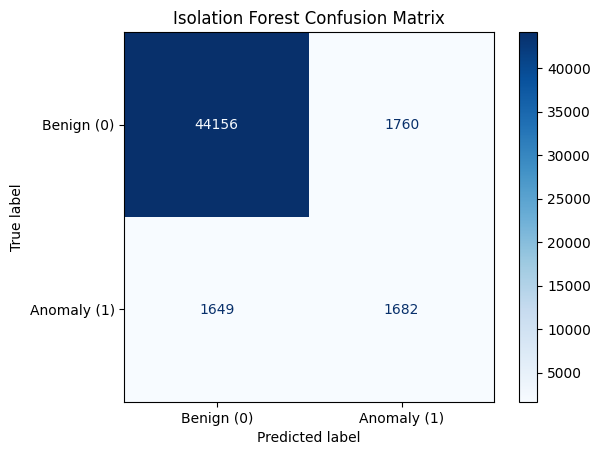


Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96     45916
     Anomaly       0.49      0.50      0.50      3331

    accuracy                           0.93     49247
   macro avg       0.73      0.73      0.73     49247
weighted avg       0.93      0.93      0.93     49247

Number of trees: 500


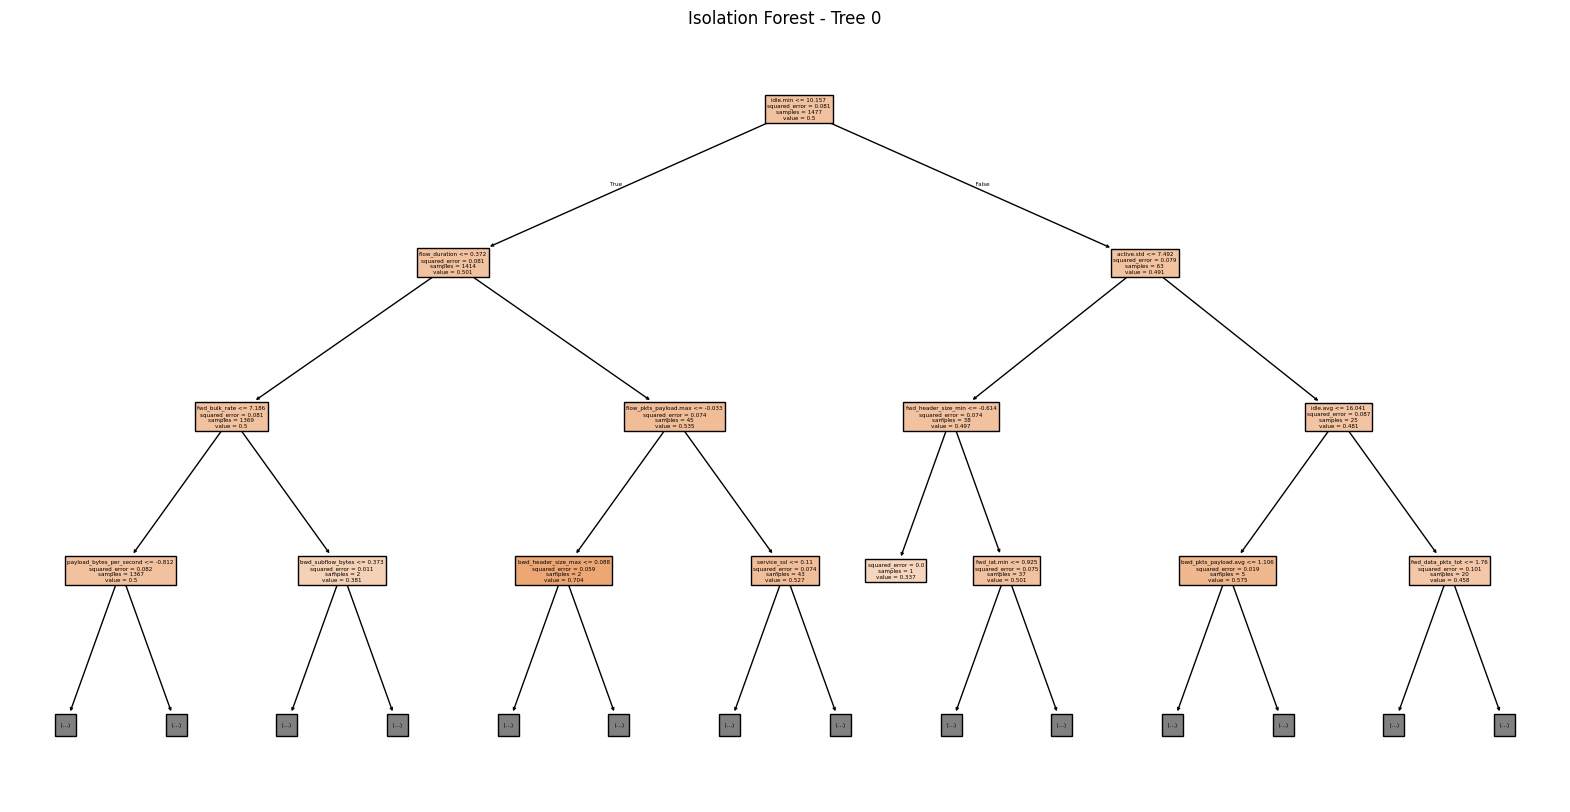

In [9]:
y_train_pred = clf.labels_
y_train_scores = clf.decision_scores_

y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nEvaluation On Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)

print("\nEvaluation On Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

# example of the feature importance
feature_importance = clf.feature_importances_
print(feature_names)
for i, v in enumerate(feature_importance):
    print(f'Feature: {feature_names[i]}, Score: {v:.5f}')
print("Feature importance", feature_importance)


# Sort and display top 10 features by importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)
print("\nTop 10 features by importance:")
for i, row in importance_df.head(10).iterrows():
    print(f"{i+1:2d}. {row['Feature']:30s} {row['Importance']:.6f}")
# Features with no importance
print("\nFeatures with no importance:")
for i, row in importance_df[importance_df['Importance'] == 0].iterrows():
    print(f"{i+1:2d}. {row['Feature']:30s} {row['Importance']:.6f}")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display as text
print("\nConfusion Matrix:")
print(cm)

# Pretty plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign (0)", "Anomaly (1)"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Isolation Forest Confusion Matrix")
plt.show()

# Classification report for precision, recall, F1
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=["Benign", "Anomaly"]))

sklearn_iforest = clf.detector_  # The underlying sklearn IsolationForest
trees = sklearn_iforest.estimators_
print(f"Number of trees: {len(trees)}")

plt.figure(figsize=(20, 10))
tree.plot_tree(
    trees[0],  # visualize the first tree
    filled=True,
    feature_names=X.columns,
    max_depth=3  # limit depth for readability
)
plt.title("Isolation Forest - Tree 0")
plt.show()




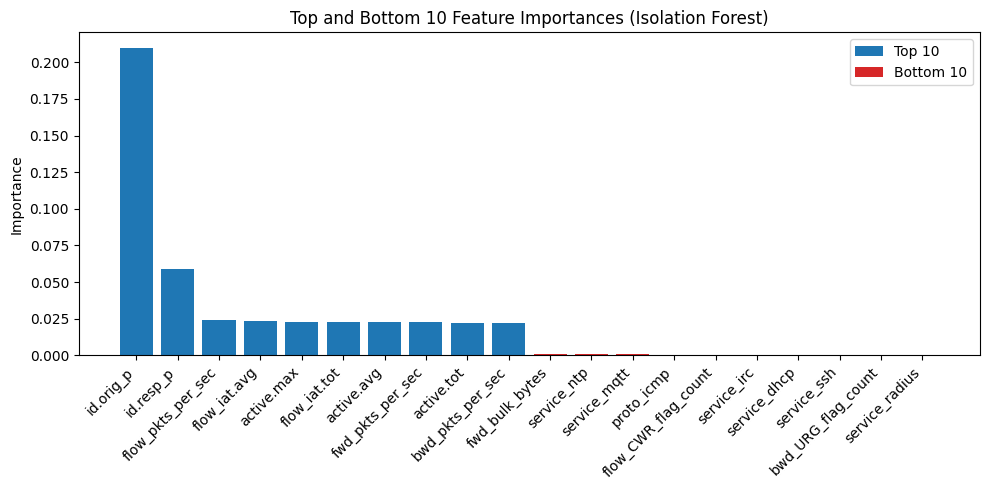

In [10]:
# Plot
plt.figure(figsize=(10, 5))

# Combine both in one bar chart
plt.bar(importance_df.head(10)["Feature"], importance_df.head(10)["Importance"], color="tab:blue", label="Top 10")
plt.bar(importance_df.tail(10)["Feature"], importance_df.tail(10)["Importance"], color="tab:red", label="Bottom 10")

plt.title("Top and Bottom 10 Feature Importances (Isolation Forest)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Importance")
plt.legend()
plt.tight_layout()
plt.show()


Top 5 most anomalous samples:


,id.orig_p,id.resp_p,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,...,service_dns,service_http,service_irc,service_mqtt,service_ntp,service_radius,service_ssh,service_ssl,score,label
97314,-0.015031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.222486,0
96046,-0.015476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.222486,0
53452,-0.015563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.222486,0
53539,-0.014722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.222486,0
53447,-0.015611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.222486,0


Top 10 feature deviations for this anomaly:
fwd_pkts_payload.min    1.000000
flow_RST_flag_count     1.000000
service_-               1.000000
bwd_pkts_payload.avg    0.829498
bwd_pkts_payload.max    0.750914
bwd_pkts_per_sec        0.750887
fwd_pkts_per_sec        0.729562
bwd_pkts_payload.tot    0.719444
bwd_subflow_bytes       0.701489
flow_pkts_per_sec       0.701223
dtype: float64


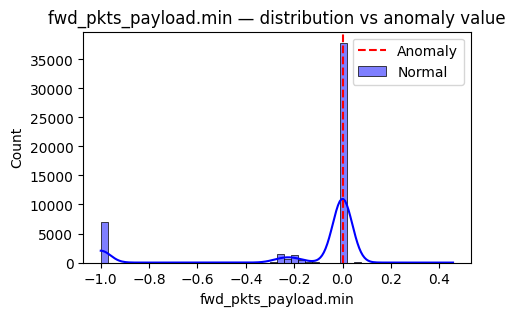

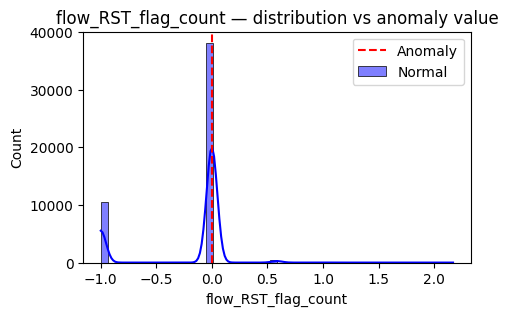

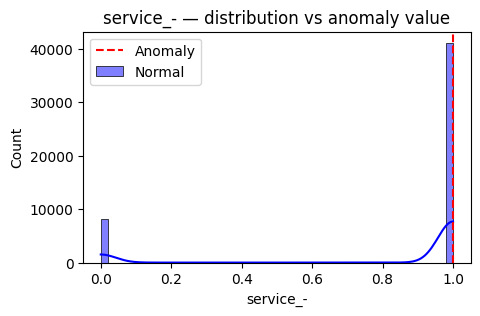

In [11]:
# Lower scores = more anomalous
X_test_anomalies = X_test.copy()
X_test_anomalies["score"] = y_test_scores
X_test_anomalies["label"] = y_test_pred

# Sort anomalies by score (lowest first)
top_anomalies = X_test_anomalies.sort_values(by="score", ascending=True).head(5)
print("Top 5 most anomalous samples:")
display(top_anomalies)

# Compute median of normal samples for reference
normal_median = X_test[y_test_pred == 1].median()

# Pick one example anomaly
anomaly_idx = top_anomalies.index[0]
anomaly = X_test.loc[anomaly_idx]

# Compute deviation from normal behavior
deviation = (anomaly - normal_median).abs().sort_values(ascending=False)
print("Top 10 feature deviations for this anomaly:")
print(deviation.head(10))

import seaborn as sns

top_features = deviation.head(3).index  # 3 most deviating features

for feature in top_features:
    plt.figure(figsize=(5,3))
    sns.histplot(X_test[feature], bins=50, kde=True, color="blue", label="Normal")
    plt.axvline(anomaly[feature], color="red", linestyle="--", label="Anomaly")
    plt.title(f"{feature} — distribution vs anomaly value")
    plt.legend()
    plt.show()





In [18]:
!pip3 install -U suod
from pyod.models.suod import SUOD
from pyod.models.lof import LOF
from pyod.models.iforest import IForest


# initialized a group of outlier detectors for acceleration
detector_list = [LOF(n_neighbors=15), LOF(n_neighbors=20),
                 LOF(n_neighbors=25), LOF(n_neighbors=35),
                 IForest(n_estimators=100),
                 IForest(n_estimators=200)]

# decide the number of parallel process, and the combination method
# then clf can be used as any outlier detection model
clf = SUOD(base_estimators=detector_list, combination='average',
           verbose=False, n_jobs=4)

RandomForestRegressor()



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   17.2s remaining:   17.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 47.6min finished


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   11.7s remaining:   11.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   13.0s finished


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.2s remaining:    5.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   10.1s finished



Evaluation On Training Data:
IForest ROC:0.9437, precision @ rank n:0.4485

Evaluation On Test Data:
IForest ROC:0.9444, precision @ rank n:0.4563

Confusion Matrix:
[[43052  2864]
 [ 1215  2116]]


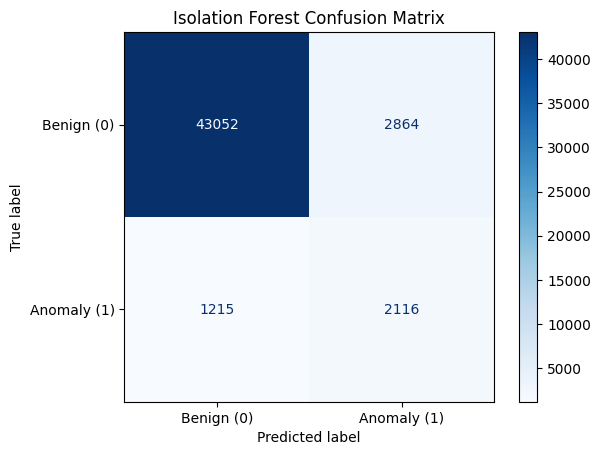


Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.94      0.95     45916
     Anomaly       0.42      0.64      0.51      3331

    accuracy                           0.92     49247
   macro avg       0.70      0.79      0.73     49247
weighted avg       0.94      0.92      0.92     49247



In [19]:
clf.fit(X_train)

y_train_pred = clf.labels_
y_train_scores = clf.decision_scores_

y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nEvaluation On Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)

print("\nEvaluation On Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display as text
print("\nConfusion Matrix:")
print(cm)

# Pretty plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign (0)", "Anomaly (1)"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Isolation Forest Confusion Matrix")
plt.show()

# Classification report for precision, recall, F1
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=["Benign", "Anomaly"]))

